# Project 5: Depth Estimation using Stereo

## Part 1: Simple stereo by matching patches

We know that there is some encoding of depth when the images are captured using a stereo rig, much like human eyes.


You can try a simple experiment to see the stereo effect in action. Try seeing a scene with only your left eye. Then close your left eye and see using your right eye. Make the transition quickly. You should notice a horizontal shift in the image perceived. Can you comment on the difference in shift for different objects when you do this experiment? Is it related to the depth of the objects in some way?


In this notebook, we will generate disparity maps, which is the map of horizontal shifts estimated at each pixel. We will start working on a simple algorithm which will then be evolved to give better disparity maps.

## Setup

1. Install Miniconda. It doesn’t matter whether you use Python 2 or 3 because we will create our own environment that uses 3 anyways.
2. Create a conda environment using the appropriate command. On Windows, open the installed “Conda prompt” to run the command. On MacOS and Linux, you can just use a terminal window to run the command, Modify the command based on your OS (linux, mac, or win): `conda env create -f proj5_env_<OS>.yml`
3. This should create an environment named ‘proj5’. Activate it using the Windows command, activate proj5 or the MacOS / Linux command, source activate proj5
4. Install the project package, by running `pip install -e .` inside the repo folder.
5. Run the notebook using `jupyter notebook ./proj5_code/simple_stereo.ipynb`
6. Ensure that all sanity checks are passing by running pytest inside the “unit_tests/” folder.
7. Generate the zip folder for the code portion of your submission once you’ve finished the project using `python zip_submission.py --username <your_uid>` and submit to Canvas.

## Writeup

For this project, you must do a project report using the template slides provided to you. Do not change the order of the slides or remove any slides, as this will affect the grading process on Gradescope and you will be deducted points. In the report you will describe your algorithm and any decisions you made to write your algorithm a particular way. Then you will show and discuss the results of your algorithm. The template slides provide guidance for what you should include in your report. A good writeup doesn’t just show results–it tries to draw some conclusions from the experiments. You must convert the slide deck into a PDF for your submission.

If you choose to do anything extra, add slides after the slides given in the template deck to describe your implementation, results, and analysis. Adding slides in between the report template will cause issues with Gradescope, and you will be deducted points. You will not receive full credit for your extra credit implementations if they are not described adequately in your writeup.

## Rubric (Total : 100 pts)
* 60 pts: Code
    * 15 pts: generate_random_stereogram in utils.py
    * 15 pts: similarity_measures.py
    * 30 pts: disparity_map.py
* 40 pts: Report
* -5*n pts: Lose 5 points for every time you do not follow the instructions for the hand-in format.

In [243]:
import sys
sys.path.append('..')

from proj5_code.utils import load_image, PIL_resize, generate_random_stereogram, stereo_helper_fn
from proj5_code.disparity_map import calculate_disparity_map
from proj5_code.similarity_measures import ssd_similarity_measure, sad_similarity_measure

import torch
import numpy as np

import matplotlib.pyplot as plt

from unit_tests.test_base import verify

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will use a helper function called stereo_helper_fn for utils.py for calculating and plotting the disparity maps using the functions defined by you

## Random dot stereogram

It was once believed that in order to perceive depth, one must either match feature points (like SIFT) between left and right images, or rely upon cues such as shadows.

A random dot stereogram eliminates all other depth cues and hence it proves that a stereo setup is sufficient to get an idea of the depth of the scene.

A random dot stereogram is generated by the follow steps:
1. Create the left image with random dots at each pixel (0/1 values).
2. Create the right image as the copy of left image.
3. Select a region in the right image and shift it horizontally.
4. Add a random pattern in the right image in the empty region created after the shift.

You will implement these steps in the function `generate_random_stereogram()` in `utils.py`. A corresponding unit test is defined in test_utils.py.

Please read the documentation carefully.

#### Reflection Question:
1. What do you think of the random dot stereogram? Can you judge the depth by looking at the images?

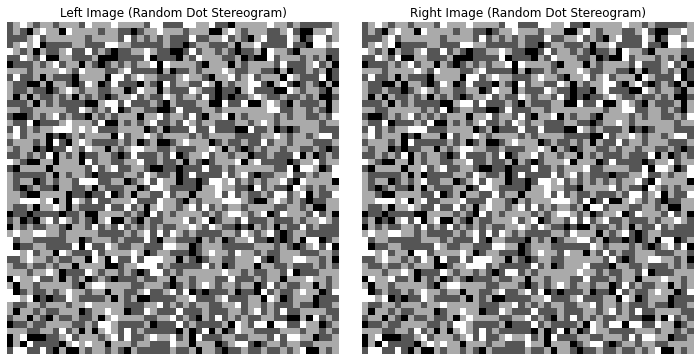

In [244]:
#generate left and right images
im_left, im_right = generate_random_stereogram(im_size=(51, 51, 3))

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(im_left)
plt.title("Left Image (Random Dot Stereogram)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(im_right)
plt.title("Right Image (Random Dot Stereogram)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [245]:
from unit_tests.test_utils import test_generate_random_stereogram

print('Test for random dot stereogram', verify(test_generate_random_stereogram))

Test for random dot stereogram "Correct"


## Similarity measure


We will use a similarity function to compare patches between left and right images. We will implement two similarity functions:

1. Sum of squared differences (SSD): $SSD\left(A,B\right) = \sum_{i,j}\left(A_{ij} - B_{ij}\right)^2$
2. Sum of absolute differences (SAD): $SAD\left(A,B\right) = \sum_{i,j}|A_{ij} - B_{ij}|$

You will implement these functions in `similarity_measures.py`. The corresponding unit tests are defined in `test_similarity_measures.py`.

Implement the similarity function and disparity map calculation. You will need it in the next steps

In [246]:
from unit_tests.test_similarity_measures import (
  test_ssd_similarity_measure_values, 
  test_sad_similarity_measure_values, 
  test_similarity_measure_size_compatibility
)

print('Testing value for SAD measure', verify(test_sad_similarity_measure_values))
print('Testing value for SSD measure', verify(test_ssd_similarity_measure_values))
print('Testing input size compatibility for measures', verify(test_similarity_measure_size_compatibility))

  

Testing value for SAD measure "Correct"
Testing value for SSD measure "Correct"
Testing input size compatibility for measures "Correct"


## Disparity Map

We are now ready to write the code for a simple algorithm for stereo matching.

<figure>
    <img src="figures/disparity_calculation_example.jpg" width="600" title="Example of a stereo algorithm" />
    <center><figcaption align="center">Example of a stereo algorithm</figcaption></center>
</figure>

These are the steps taken in this image (and will be implemented by you):

1. Pick a patch in the left image (red block), P1.
2. Place the patch in the same (x,y) coordinates in the right image (red block). As this is binocular stereo, we will need to search for P1 on the left side starting from this position. Make sure you understand this point well before proceeding further.
4. Slide the block of candidates to the left (indicated by the different pink blocks). The search area is restricted by the parameter max_search_bound in the code. The candidates will overlap.
5. We will pick the candidate patch with the minimum similarity error (green block). The horizontal shift from the red block to the green block in this image is the disparity value for the centre of P1 in the left image.

Note: the images have already been rectified and hence we can search on just a horizontal scan line.

The function works as follows:

* Input
    1. Left image
    2. Right image
    3. Similarity function
    4. Patch size
    5. Max search value
* Output
    1. Disparity map

Implement this in `disparity_map.py` (please read the documentation carefully!). The corresponding unit tests are defined in `test_disparity_map.py`.

**Deliverables**:
All the disparity maps
+
Observations and Analysis:

#### Reflection Question
1. What is the effect of increasing the block size? 
- Increasing the block size will reduces noise and also smooths out fine details. Alongside it will also improve results in featureless regions but reduces accuracy in highly detailed areas.



2. Why is the result poor on the left edge and not on the other edges?
- The result is poor on the left edge because there aren't enough corresponding patches in the right image to compare with. Now the algorithm searches for matches by shifting patches to the left, but there would be no valid area in the right image for the leftmost pixels.


In [247]:
from unit_tests.test_disparity_map import (
  test_disparity_deltafn_failure,
  test_disparity_deltafn_success,
  test_disparity_map_size,
  test_disparity_random_stereogram,
  test_disparity_translation_shift
)

In [248]:
print('Testing for disparity map on a delta function', verify(test_disparity_deltafn_failure))
print('Testing for disparity map on a delta function', verify(test_disparity_deltafn_success))
print('Testing disparity map size', verify(test_disparity_map_size))
print('Testing random stereogram ouptut', verify(test_disparity_random_stereogram))
print('Testing disparity on translation shift', verify(test_disparity_translation_shift))

tensor([[42, 19]])
Testing for disparity map on a delta function "Correct"
Testing for disparity map on a delta function "Correct"
Testing disparity map size "Correct"
Testing random stereogram ouptut "Correct"
Testing disparity on translation shift "Correct"


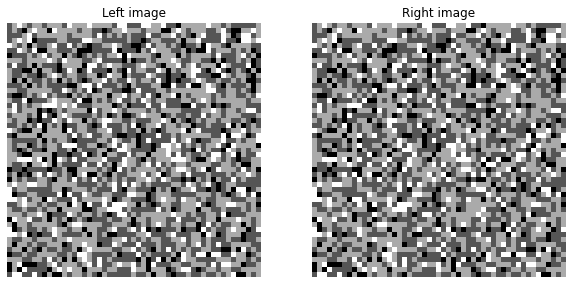

..\proj5_code\utils.py:154: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  im = ax2.imshow(disp_map_ssd, cmap='jet')
..\proj5_code\utils.py:160: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.show()


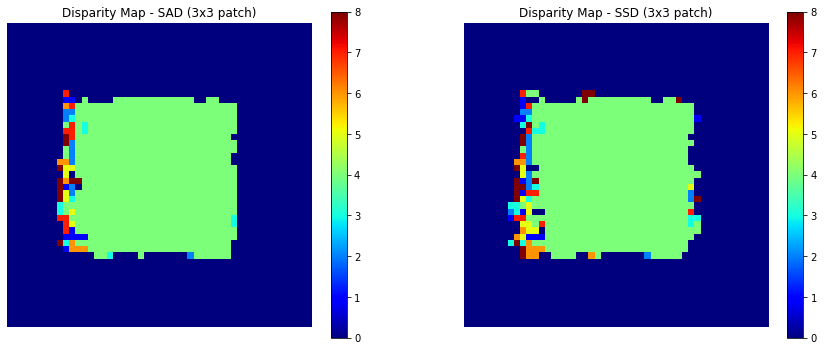

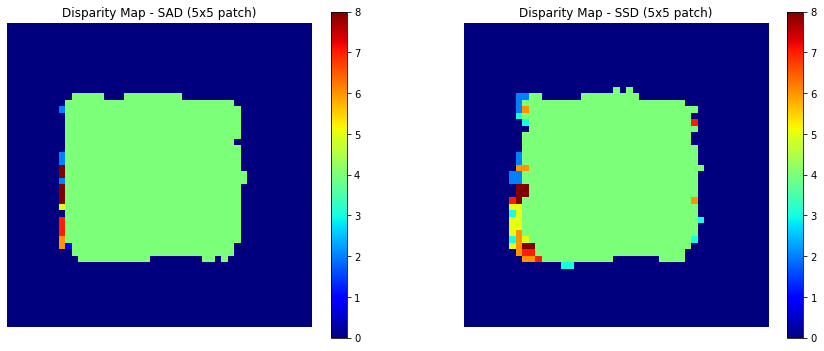

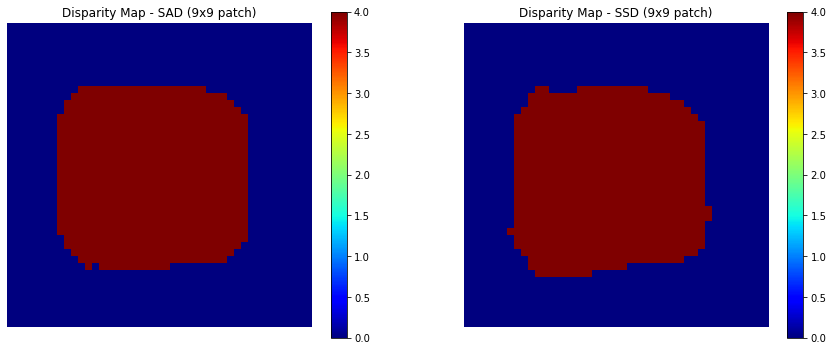

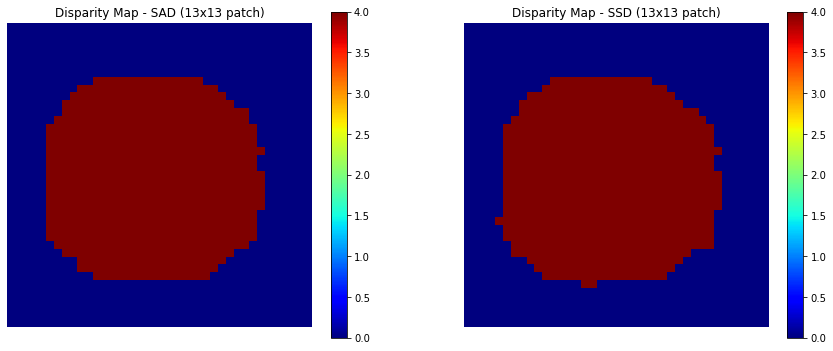

In [249]:
stereo_helper_fn(im_left, im_right, block_size = [3,5,9,13], max_search_bound=8)

## Error profile analysis

In the error profile analysis, you have to find two examples which display convex and non-convex error profile respectively. For reference, these are the plots we obtained:

<figure>
    <img src="figures/convex_sample.png" title="Convex Sample" />
    <center><figcaption align = "center">Convex Profile</figcaption></center>
</figure>
<figure>
    <img src="figures/non_convex_sample.png" title="Non Convex Sample" />
    <center><figcaption align = "center">Non-Convex Profile</figcaption></center>
</figure>

Before computing the full disparity map, we will analyse the similarity error between patches. You will have to find out different patches in the image which exhibit a close-to-convex error profile, and a highly non-convex profile.

**Deliverable**:
Find the patch in the left image and search space in the right image, and the similarity error plot for the two cases, and copy it to the report

In [250]:
# Load the image
base_path = '../data/adirondack/'
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.1, 0.1))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.1, 0.1))

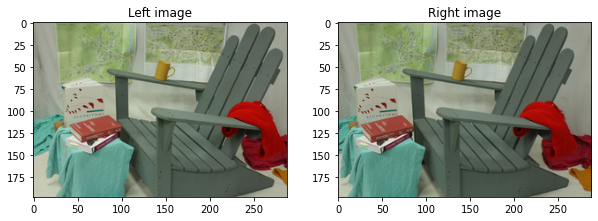

In [251]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))

ax1.imshow(im_left, interpolation=None)
ax1.title.set_text('Left image')
ax1.autoscale(False)
ax1.set_axis_on()

ax2.imshow(im_right, interpolation=None)
ax2.title.set_text('Right image')
ax2.autoscale(False)
ax2.set_axis_on()

plt.show()

## Convex error profile

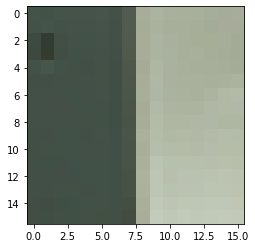

In [252]:
# extract a patch of interest from the left image
patch_size=15
x_idx, y_idx = (80,100) # TODO: replace with integers
patch_left_img = torch.tensor(im_left[x_idx:x_idx+patch_size+1, y_idx:y_idx+patch_size+1,:])
plt.imshow(patch_left_img)
plt.show()

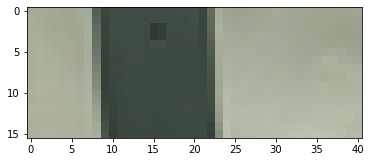

In [253]:
# get the search area in the right image
max_search_bound = 25 # might need adjustment based on your (x_idx, y_idx)
search_area_right_img = torch.tensor(
  im_right[x_idx:x_idx+patch_size+1, y_idx-max_search_bound:y_idx+patch_size+1,:]
)
plt.imshow(search_area_right_img)
plt.show()

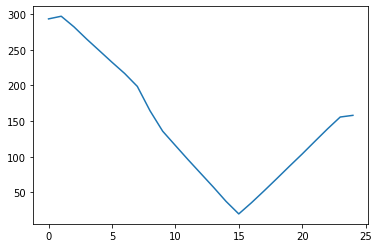

In [254]:
similarity_vals = np.array(
  [sad_similarity_measure(patch_left_img, search_area_right_img[:,h_idx:h_idx+patch_size+1,:]) 
   for h_idx in range(search_area_right_img.shape[1]-patch_size-1)
  ])
plt.plot(similarity_vals)
plt.show()

## Non-Convex error profile

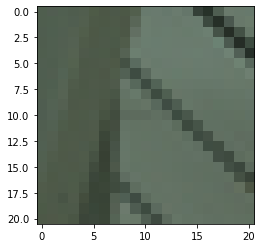

In [255]:
# extract a patch of interest from the left image
patch_size=20
x_idx, y_idx = (120, 150) # TODO: replace with integers
patch_left_img = torch.tensor(im_left[x_idx:x_idx+patch_size+1, y_idx:y_idx+patch_size+1,:])
plt.imshow(patch_left_img)
plt.show()

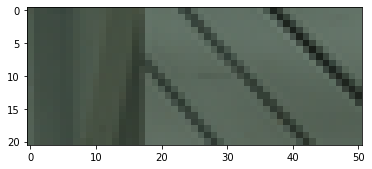

In [256]:
# get the search area in the right image
max_search_bound = 30# might need adjustment based on your (x_idx, y_idx)
search_area_right_img = torch.tensor(
  im_right[x_idx:x_idx+patch_size+1, y_idx-max_search_bound:y_idx+patch_size+1,:]
)
plt.imshow(search_area_right_img)
plt.show()

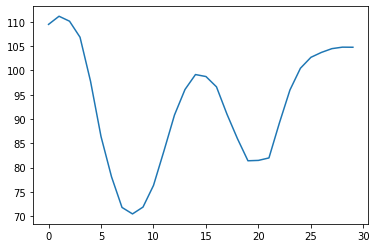

In [257]:
similarity_vals = np.array(
  [sad_similarity_measure(patch_left_img, search_area_right_img[:,h_idx:h_idx+patch_size+1,:]) 
   for h_idx in range(search_area_right_img.shape[1]-patch_size-1)
  ])
plt.plot(similarity_vals)
plt.show()

# Real life stereo images

## Example 1

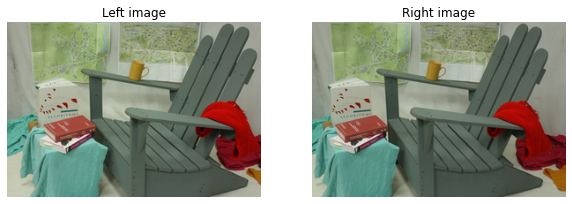

..\proj5_code\utils.py:154: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  im = ax2.imshow(disp_map_ssd, cmap='jet')
..\proj5_code\utils.py:160: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.show()


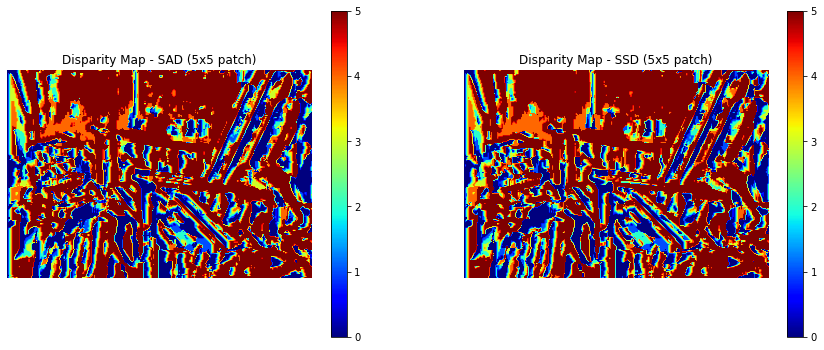

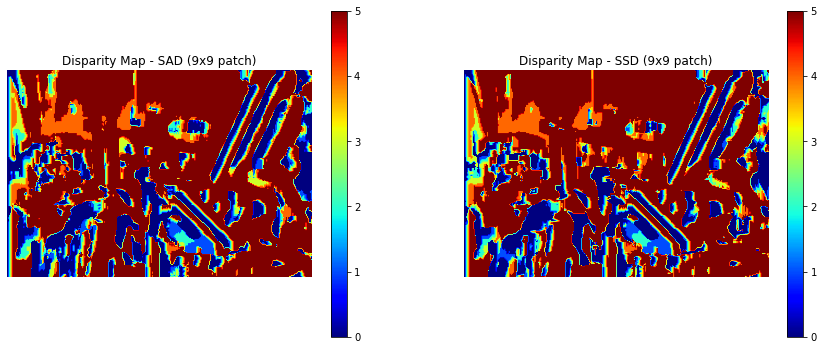

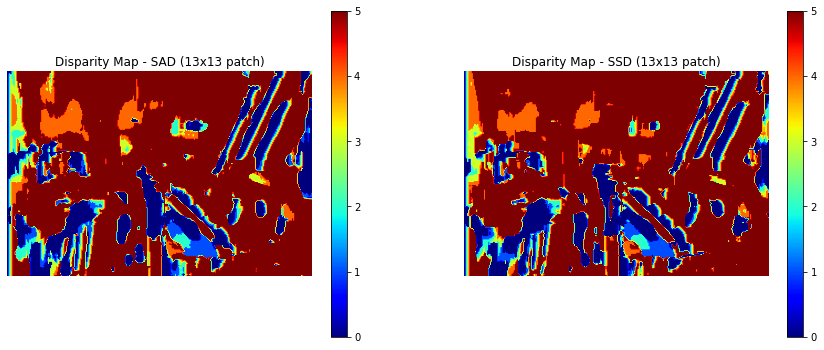

In [258]:
stereo_helper_fn(torch.tensor(im_left), torch.tensor(im_right), max_search_bound=5)

**Deliverables**
1. Copy the disparity map for the patch size you feel works the best
2. Can you think of an explanation as to why the back rest of the chair appears *blocky*?

Tip: you can see all the examples and deliverables before answering. This will help you understand the core ideas being asked.


#### 1.
   - The disparity maps for patch sizes 9x9 or 11x11 seem to work best. They strike a good balance between reducing noise and maintaining the details. Larger patches help smooth out the image and reduce noise. 
   However they sometimes miss finer details. The choice of patch size will determine smoothness or intricate details.

#### 2.
   - The backrest looks blocky because larger patch sizes are used to calculate the disparity. When larger patches are averaged, sharp depth changes or small details can get smoothed out, leading to a blocky appearance. 
   - Additionally, the backrest might not have enough texture or distinct features for the algorithm to clearly match disparities.

## Set 2

In [259]:
base_path = '../data/bicycle/'
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.1, 0.1))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.1, 0.1))

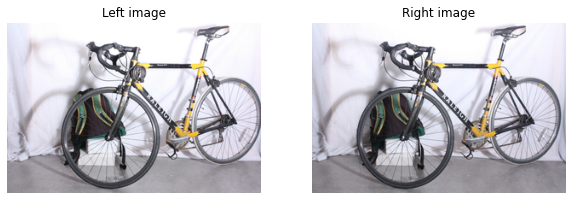

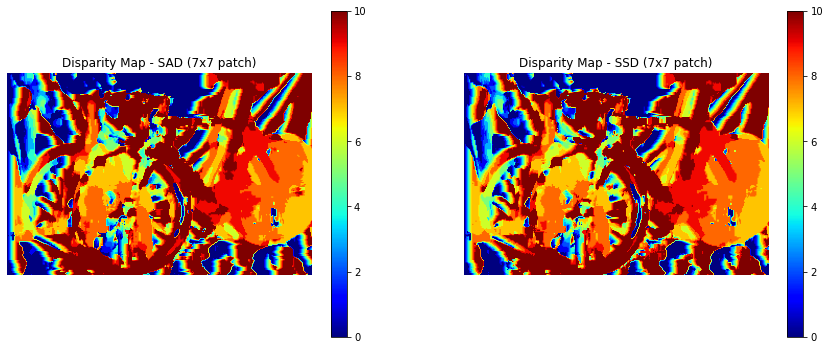

In [260]:
stereo_helper_fn(torch.tensor(im_left), torch.tensor(im_right), block_size=[7], max_search_bound=10)

## Set 3

In [261]:
base_path = '../data/bowling/'
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.2, 0.2))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.2, 0.2))

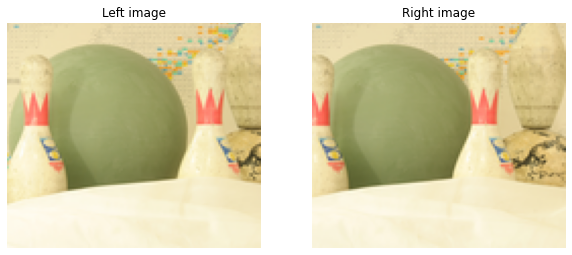

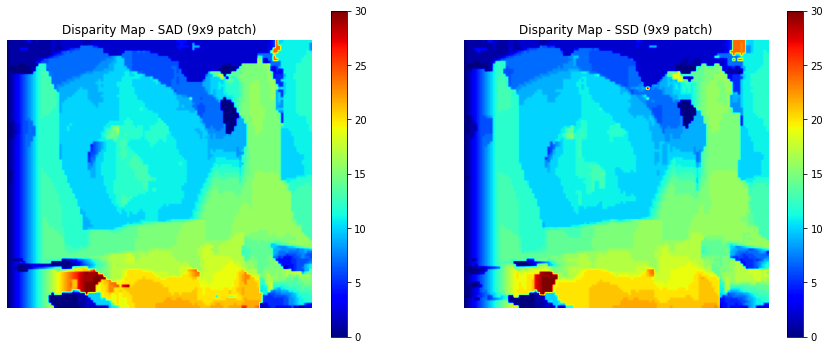

In [262]:
stereo_helper_fn(torch.tensor(im_left), torch.tensor(im_right), block_size=[9], max_search_bound=30)

## Set 4

In [263]:
base_path = '../data/bowling2/'
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.20, 0.20))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.20, 0.20))

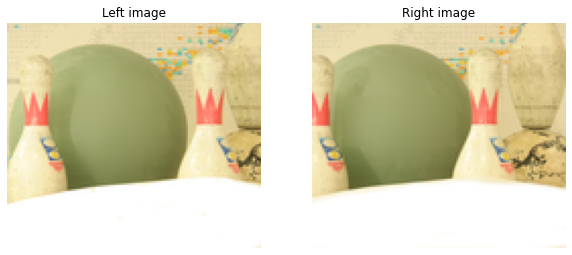

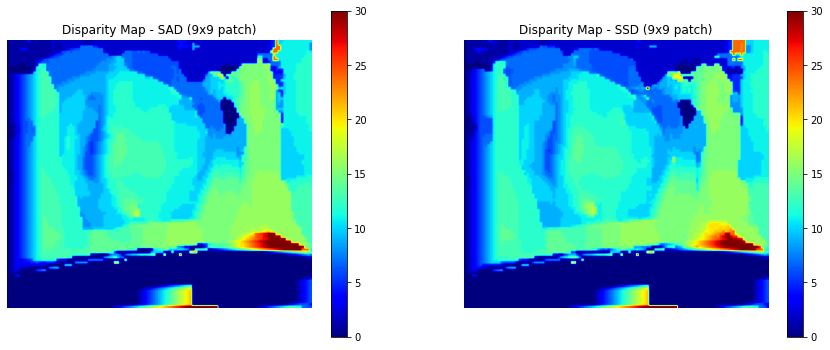

In [264]:
stereo_helper_fn(torch.tensor(im_left), torch.tensor(im_right), block_size=[9], max_search_bound=30)

**Deliverables** of set 3 and set 4 combined:

1. Copy the disparity maps from set 4 in the report
2. Can you spot a peculiar behaviour of the diaprity maps near the head of bowling pin on the right? What do you see in the input images in that area? Can you figure out the reason behind this behaviour?
3. Notice that we have manipulated the images in set 4 to generate set 4 images. This leads to a difference in disparity map results in the bottom of the image and on the green bowling ball. Can you explain why the disparity drops to zero in both these regions.

### 1.
The disparity maps for both SAD and SSD methods, using the 9x9 patch size, should be included in the report. These maps clearly show the differences in how the algorithms calculate disparity, helping to analyze the impact of the manipulated images in Set 4.

### 2. 
In the disparity maps, the head of the bowling pin on the right shows noticeable irregularities, such as sudden changes or noisy patches.
-  The head of the bowling pin is smooth and doesn’t have distinctive trextures or features, making it difficult for the algorithm to find a reliable match between the left and right images.
-  The pin’s reflective surface may cause differences in brightness or highlights between the two images, which can confuse the algorithm. This makes it hard for the similarity measure to accurately assess the match.
-  The pin’s curved and shiny surface leads to inconsistencies in how it appears in the two images. This can give in errors when calculating disparities.

### 3. 
In the manipulated Set 4 images, some areas especially near the bottom of the image and on the green bowling ball show disparities dropping to zero.
  - At the bottom, features might have been removed or shifted, making it impossible to find corresponding points between the images.
  - The green bowling ball might have been smoothed or altered, leaving little texture for the algorithm to match.


## Set 5

In [265]:
base_path = '../data/flowers/'
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.10, 0.10))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.10, 0.10))

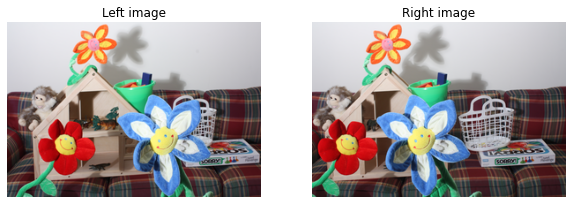

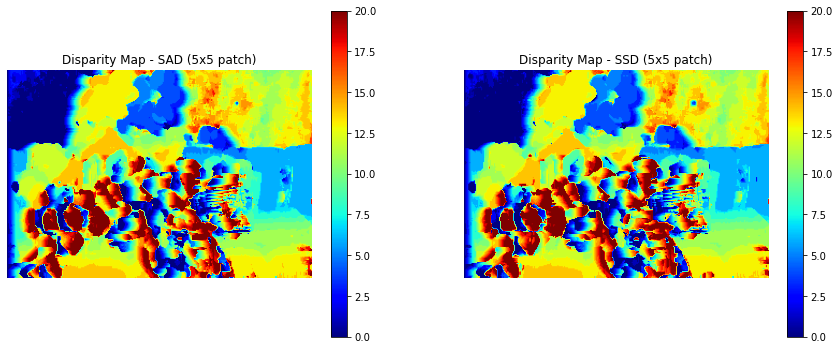

In [266]:
stereo_helper_fn(torch.tensor(im_left), torch.tensor(im_right), block_size=[5], max_search_bound=20)

**Observations**: (these observations do not go in the report. These are for your understanding).

1. Notice the different disparity of the flower at the back and its shadow
2. Spot the zero-disparity region in the center of the house
3. See how smooth the disparity values are on the couch

## Set 6

In [267]:
base_path = '../data/stairs/'
im_left = PIL_resize(load_image(base_path + 'im_left.jpg'), (1, 1))
im_right = PIL_resize(load_image(base_path + 'im_right.jpg'), (1, 1))

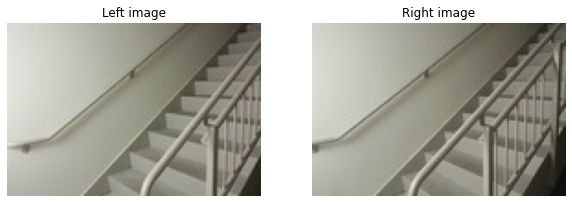

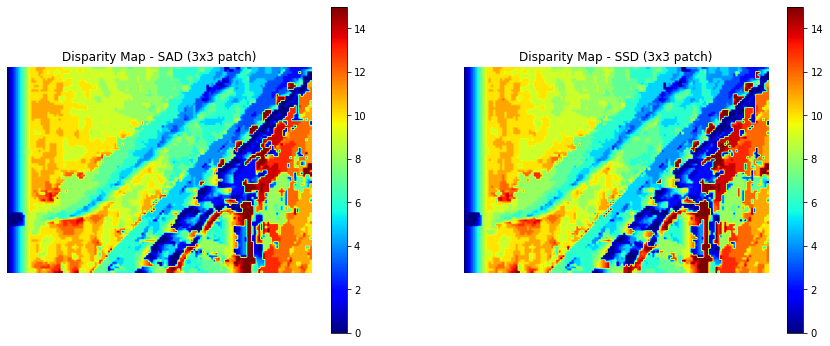

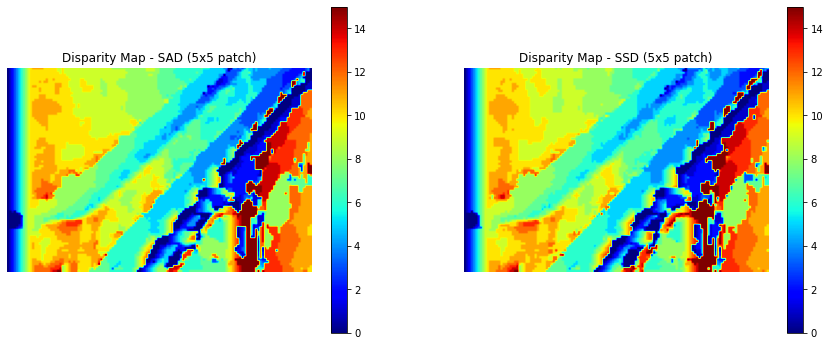

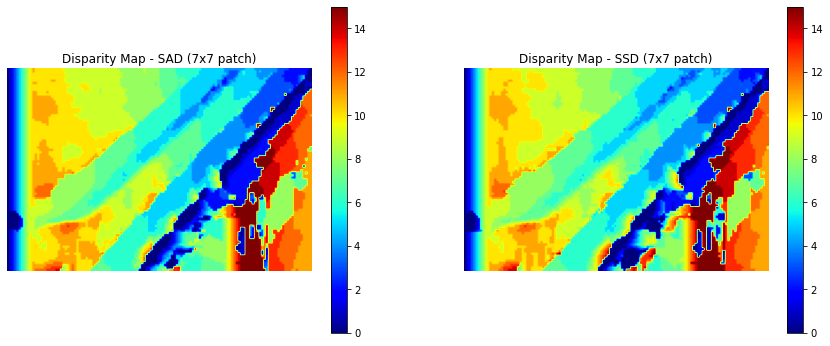

In [268]:
stereo_helper_fn(torch.tensor(im_left), torch.tensor(im_right), block_size = [3, 5, 7], max_search_bound=15)

**Deliverables**

1. Why are we able to see the shift in disparity values on the wall?
2. What is the effect of block_size and the ability to see stairs-like structure in the disparity map?

### Explanation:

#### 1.

The wall shows a noticeable shift in disparity values because of how it is angled relative to the cameras. In stereo images, surfaces that are slanted or tilted have parts that are closer to the camera and others that are farther away. This creates a change in depth, which is captured as a shift in the disparity map. 
- The wall’s smooth texture makes it easier for the algorithm to compute consistent disparity values without much interference from noise.
- The gradual variation in distance across the wall creates a clear transition of disparity, making the shift easy to make out.

#### 2. 

- Smaller Block Sizes (3x3): Smaller blocks focus on samll and localized areas, allowing the algorithm to pick up fine details. This makes the edges of the stairs-like structure sharper and more defined.But also smaller blocks can also make the disparity map noisier because they’re more sensitive to small variations in the image.
- Larger Block Sizes (7x7): Larger blocks average out the disparity over a bigger region, which smooths out the details. While this helps reduce noise, it also makes the stairs-like structure less sharp, blending the edges.

Smaller blocks capture finer details but may introduce more noise, while larger blocks smooth out the disparity map but can lose some of the sharpness in details like the stairs.

# Smoothing

One issue with the results from is that they aren't very smooth. Pixels next to each other on the same surface can have vastly different disparities, making the results look very noisy and patchy in some areas. Intuitively, pixels next to each other should have a smooth transition in disparity(unless at an object boundary or occlusion).
In this section, we try to improve our results. One way of doing this is through the use of a smoothing constraint. The smoothing method we use is called Semi-Global Matching(SGM) or Semi-Global Block Matching. Before, we picked the disparity for a pixel based on the minimum matching cost of the block using some metric(SSD or SAD). The basic idea of SGM is to penalize pixels with a disparity that's very different than their neighbors by adding a penalty term on top of the matching cost term. SGM tries to minimize the global(over the entire image) energy function
\begin{equation*}
E(D) \leq \sum_{p} (C(p, D_p) + \sum_{q} PT(|D_p - D_q|))
\end{equation*}
C(p,D_p) is the matching cost for a pixel with disparity D_p, q is a neighboring pixel, and PT is some penalty function penalizing the difference in disparities.
You can read more about how this method works and is optimized here:
https://elib.dlr.de/73119/1/180Hirschmueller.pdf
and
https://pdfs.semanticscholar.org/bcd8/4d8bd864ff903e3fe5b91bed3f2eedacc324.pdf

Before we implement the smoothing algorithm, we need to implement a function which computes the **cost volume**. We have already written code to compute disparity map. We will extend that code to compute the cost volume. Instead of taking the argmin of the similarity error profile, we will store the tensor of error profile at each pixel location along the third dimension.

If we have an input image of dimension (H,W,C) and max search bound of D, the cost_volume will be a tensor of dimension (H,W,D). The cost volumne at (i,j) pixel is the error profile obtained for the patch in the left image centered at (i,j).

Implement this part as function ```calculate_cost_volume``` in ```disparity_map.py```. Feel free to reuse any code you have written till now.

In [269]:
from unit_tests.test_disparity_map import (
  test_calculate_cost_volume
)

print('Testing for calculate_cost_volume', verify(test_calculate_cost_volume))

Testing for calculate_cost_volume "Correct"


..\proj5_code\disparity_map.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  col_offset - half_patch_size:col_offset + half_patch_size + 1,



Starting cost computation...

Starting aggregation computation...
	Processing paths east and west...	(done in 2.64 s)
	Processing paths south-east and north-west...	(done in 2.95 s)
	Processing paths south and north...	(done in 4.11 s)
	Processing paths south-west and north-east...	(done in 2.78 s)

Selecting best disparities...

Done


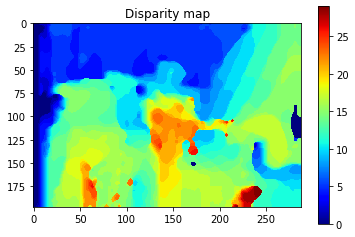

In [270]:
# Load the image
from semiglobalmatching.sgm import sgm
from scipy import ndimage
from proj5_code.similarity_measures import sad_similarity_measure, ssd_similarity_measure

#you can change the path to try other pairs, but you may need to fix the scaling per pair
base_path = '../data/adirondack/'
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.10, 0.10))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.10, 0.10))

#calculates the disparity map with SGM, the last argument is max disparity to consider
disparity_map = sgm(im_left,im_right, "result", 30, sad_similarity_measure, 9)
result = ndimage.median_filter(disparity_map, size=5)
plt.figure()
plt.imshow(result, cmap='jet', interpolation='nearest')
plt.title('Disparity map')
plt.colorbar()
plt.show()

**Deliverables**

1. Compare these results qualitatively to the output of the chair image without smoothing.
2. What regions of the image does smoothing seem to perform better on and why do you think that is?
3. What regions of the image does smoothing seem to perform worse on and why do you think that is?
4. Would smoothing still work for images with both a horizontal and vertical shift?


(Extra Credit: 5 pts)Try the above smoothing with your own image pair! Take 2 images with only(or mostly) a horizontal shift, and see the result by editing the image paths and running the code. If you get good results, explain why your image pair is "easy". If you get bad results, explain why your pair is "hard". These results go in the extra credit slides. 

 


     
#### 1. 
The disparity map with smoothing is much cleaner and less noisy compared to the one without smoothing. Smoothing helps reduce abrupt changes in disparity values across neighboring pixels, especially in areas where the disparity might be hard to determine, like flat or low-texture regions. As a result, the smoothed map looks more consistent and closer to what we’d expect in real-world depth transitions.

#### 2. 
Smoothing tends to work really well when,
- Flat Surfaces or Uniform Textures: For example, large flat walls or backgrounds where there isn’t much detail.
- Areas with Gradual Depth Changes: Such as curved objects or surfaces where the depth difference changes gradually.

These areas naturally have similar disparity values, so smoothing enhances this consistency by reducing random noise or mismatches.

#### 3. 
Smoothing doesn’t work as well when
- At the edges of objects, like where one object ends and another begins, smoothing can blur the transition, leading to incorrect disparity values at the edges.
- Small patterns or sharp corners can lose their fine details because smoothing tries to average out the disparities in these regions.

Smoothing assumes that neighboring pixels have similar disparities, which doesn’t hold true for sharp edges or fine details. This can lead to artifacts or errors in these areas.

#### 4.
Smoothing can still work for images with both horizontal and vertical shifts. However, its effectiveness depends on a few factors:
- Shift Direction: Smoothing typically works along specific directions, like horizontal or vertical. If shifts occur in both directions, the algorithm needs to handle them simultaneously, which could make it more complex.
- Textures and Features in the Image: As long as the regions being matched have good texture or clear features, smoothing can still improve the results even with mixed shifts.



In [1]:
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image
from semiglobalmatching.sgm import sgm


im_left = PIL_resize(load_image('C:/Users/disha/miniconda3/proj5_6320/proj5_6320/proj5_code/resized_left.jpg'), (0.10, 0.10))
im_right = PIL_resize(load_image('C:/Users/disha/miniconda3/proj5_6320/proj5_6320/proj5_code/resized_right.jpg'), (0.10, 0.10))

disparity_map = sgm(im_left,im_right, "result", 30, sad_similarity_measure, 9)
result = ndimage.median_filter(disparity_map, size=5)
plt.figure()
plt.imshow(result, cmap='jet', interpolation='nearest')
plt.title('Disparity map')
plt.colorbar()
plt.show()

ModuleNotFoundError: No module named 'semiglobalmatching'

In [2]:
import numpy as np

def simulate_brownian_motion(t, runs=50):
    """
    Simulate Brownian motion and count the number of origin crossings.
    
    Parameters:
        t (int): Number of steps.
        runs (int): Number of simulation runs.
    
    Returns:
        float: Average number of origin crossings.
    """
    crossings = []
    for _ in range(runs):
        position = 0
        crossing_count = 0
        for _ in range(t):
            step = np.random.choice([-1, 1])  # Step with equal probability
            new_position = position + step
            # Check for crossing the origin
            if position * new_position < 0:  # Change of sign indicates crossing
                crossing_count += 1
            position = new_position
        crossings.append(crossing_count)
    return np.mean(crossings)

# Simulate for t = 4*10^4, 9*10^4, 16*10^4
t_values = [4 * 10**4, 9 * 10**4, 16 * 10**4]
results = {f"t = {t}": simulate_brownian_motion(t) for t in t_values}

# Display results
for t, crossings in results.items():
    print(f"{t}: {crossings:.2f} crossings")


t = 40000: 0.00 crossings
t = 90000: 0.00 crossings
t = 160000: 0.00 crossings
